In [1]:
import tensorflow as tf
//tensorflow: Google tarafından geliştirilen, makine öğrenimi ve derin öğrenme için kullanılan güçlü bir açık kaynak kütüphanedir.

In [3]:
print("TensorFlow version:", tf.__version__)
//tf.__version__: TensorFlow kütüphanesinin yüklü olan sürüm numarasını veren özel bir değişkendir

TensorFlow version: 2.19.0


In [7]:
from tensorflow.keras.layers import Conv2D,Flatten,Dense,Dropout,MaxPooling2D,BatchNormalization,AveragePooling2D,GlobalAveragePooling2D,SeparableConv2D,Activation,Add,Input

Conv2D (Evrişim Katmanı): Görüntülerdeki temel desenleri, kenarları, çizgileri, 
dokuları vb. tanımak için kullanılan 2D evrişim katmanıdır. Filtre (kernel) uygulayarak bu desenleri çıkarır.
Evrişim katmanları genellikle görüntüdeki önemli öznitelikleri öğrenir.

Flatten (Düzleştirme): Çok boyutlu (örneğin 2D) veriyi, tek boyutlu bir vektöre çevirir. 
Bu dönüşüm, özellikle fully connected katmanlara (Dense) geçiş yapabilmek için gereklidir.

Dense (Tam Bağlantılı Katman): Her nöron, bir önceki katmandaki tüm nöronlarla bağlantılıdır. 
Bu katman, genellikle modelin karar mekanizmasıdır ve çıkış sınıfını belirlemek için kullanılır.

Dropout (Nöronları Geçici Devre Dışı Bırakma): Eğitim sırasında bazı nöronları rastgele devre dışı bırakır. 
Bu, modelin overfitting (aşırı öğrenme) yapmasını engeller ve genelleme yeteneğini artırır.

MaxPooling2D / AveragePooling2D (Havuzlama Katmanları): Görüntü boyutlarını küçültmek için kullanılır. 
MaxPooling, belirli bir alandaki maksimum değeri alırken, AveragePooling ortalama değeri alır. 
Bu işlemler, modelin daha hızlı öğrenmesine yardımcı olur.

GlobalAveragePooling2D: Görüntüdeki her bir filtre haritasının ortalamasını alarak görüntünün daha özet bir temsilini oluşturur.
Bu, özellikle modelin son katmanlarına yakın yerlerde kullanılır ve parametre sayısını azaltır.

BatchNormalization (Toplu Normalizasyon): Modelin eğitim sürecini hızlandırmak ve kararlılığını artırmak için
her mini-batch verisini normalize eder. Bu, ağın daha stabil bir şekilde öğrenmesini sağlar.

SeparableConv2D (Ayrılabilir Evrişim): Standart Conv2D katmanlarına göre daha hafif bir alternatiftir. 
Bu, evrişim işlemini iki adımda gerçekleştirir: ilk olarak her kanal için ayrı filtre uygular (depthwise), 
sonra bu çıktıların birleşiminden yeni filtreler oluşturur (pointwise). Mobil cihazlarda yaygın olarak kullanılır.

Activation (Aktivasyon Fonksiyonları): Her nöronun ne kadar aktif olacağını belirler. 
Yaygın kullanılan aktivasyon fonksiyonları şunlardır:

ReLU: Negatif değerleri sıfır yapar, pozitif değerleri olduğu gibi bırakır.

Sigmoid: 0 ile 1 arasında değerler döndürür, genellikle ikili sınıflandırma problemlerinde kullanılır.

Softmax: Çok sınıflı sınıflandırmalarda, her sınıfın olasılığını döndürür ve toplamları 1 olur.

Add (Toplama Katmanı): İki veya daha fazla katmanın çıktılarını toplar. 
Genellikle derin ağlarda residual bağlantılar (örneğin ResNet) için kullanılır. 
Bu, ağın daha derin olmasına rağmen daha kolay öğrenmesini sağlar.

Input (Giriş Katmanı): Modelin aldığı giriş verisini tanımlar. Örneğin, bir görüntü modelinde
giriş boyutu (224, 224, 3) olabilir, yani model 224x224 boyutlarında, RGB formatında (3 kanal) görüntüler alır.

from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import glob as glb
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
import cv2 
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.regularizers import l2
import os
import shutil
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers 
import pandas as pd
import seaborn as sea

In [17]:
train_path = "D:/Data/image_data/train"
test_path = "D:/Data/image_data/test"

In [19]:
def create_pd_series(path):
    filepaths = []
    labels = []

    folds = os.listdir(path)
    for fold in folds:
        foldpath = os.path.join(path, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            files=os.path.join(foldpath,file)
             
            filepaths.append(files)
            labels.append(fold)

    Fseries=pd.Series(filepaths,name='filepaths')
    Lseries=pd.Series(labels,name='labels')
    df=pd.concat([Fseries,Lseries],axis=1)
        
    return df

In [21]:
train_df = create_pd_series(train_path)                                        

In [23]:
train_df

,filepaths,labels
0,D:/Data/image_data/train\angry\Training_101184...,angry
1,D:/Data/image_data/train\angry\Training_101204...,angry
2,D:/Data/image_data/train\angry\Training_101313...,angry
3,D:/Data/image_data/train\angry\Training_101615...,angry
4,D:/Data/image_data/train\angry\Training_102183...,angry
...,...,...
28268,D:/Data/image_data/train\surprise\Training_999...,surprise
28269,D:/Data/image_data/train\surprise\Training_999...,surprise
28270,D:/Data/image_data/train\surprise\Training_999...,surprise
28271,D:/Data/image_data/train\surprise\Training_999...,surprise


In [9]:
train_df['labels'].value_counts()

labels
happy       7215
neutral     4965
sad         4830
fear        4097
angry       3995
surprise    3171
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='labels'>

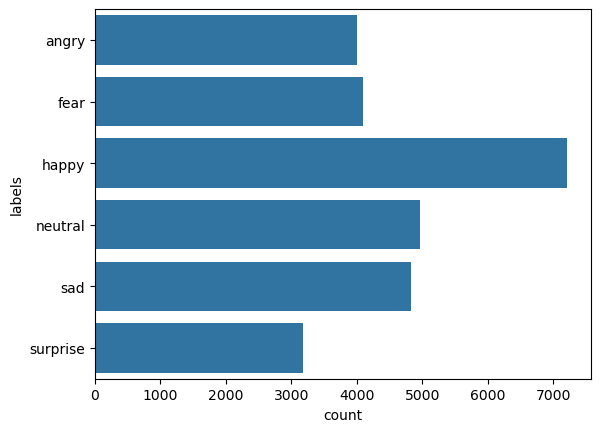

In [10]:
sea.countplot(train_df['labels'])

In [11]:
test_df = create_pd_series(test_path)  

<Axes: xlabel='count', ylabel='labels'>

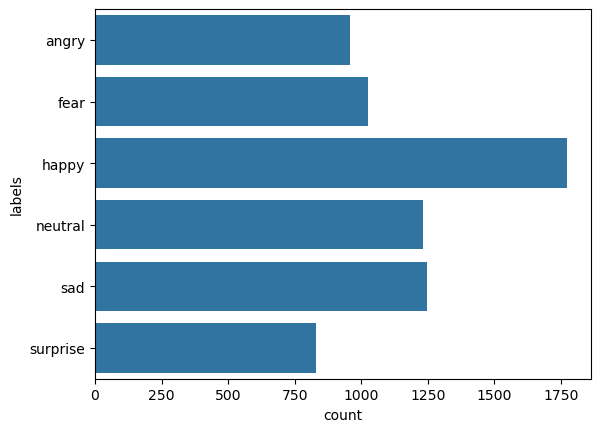

In [12]:
sea.countplot(test_df["labels"])

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
test_new_df, val_df = train_test_split(
    test_df,
    test_size=0.5,  
    shuffle=True,
    random_state=42,
    stratify=test_df['labels']  )


In [15]:
val_df['labels']

2992       happy
533        angry
153        angry
4122     neutral
3402       happy
          ...   
6532    surprise
6646    surprise
4823     neutral
5606         sad
4997         sad
Name: labels, Length: 3534, dtype: object

<Axes: xlabel='count', ylabel='labels'>

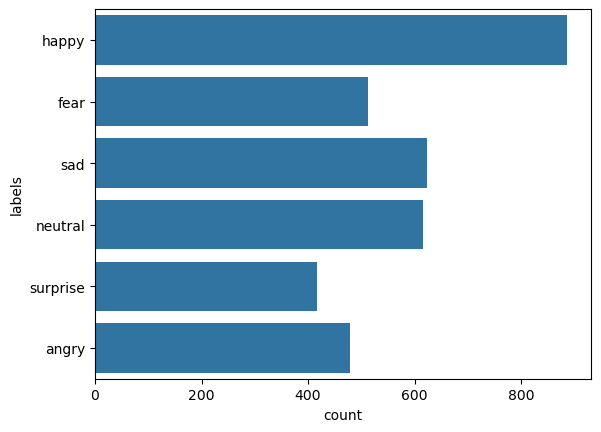

In [16]:
sea.countplot(test_new_df["labels"])

In [17]:
batch_size = 64
img_size = (48, 48)
channels = 1
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(rotation_range = 10,
                            zoom_range = 0.2,
                            shear_range = 0.2,
                            fill_mode ='nearest',
                            horizontal_flip = True )
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, 
                                       x_col = 'filepaths', 
                                       y_col = 'labels', 
                                       target_size = img_size, 
                                       class_mode = 'sparse',
                                      color_mode = 'grayscale',
                                       shuffle = True, 
                                       batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test_new_df, 
                                      x_col = 'filepaths',
                                      y_col = 'labels',
                                      target_size = img_size,
                                      class_mode = 'sparse',
                                     color_mode = 'grayscale',
                                      shuffle = False,
                                      batch_size = batch_size)
val_gen = ts_gen.flow_from_dataframe(val_df,
                                     x_col = 'filepaths',
                                     y_col = 'labels',
                                     target_size = img_size,
                                     class_mode = 'sparse',
                                    color_mode = 'grayscale',
                                     shuffle = False,
                                     batch_size = batch_size)


Found 28273 validated image filenames belonging to 6 classes.
Found 3533 validated image filenames belonging to 6 classes.
Found 3534 validated image filenames belonging to 6 classes.


In [27]:
len(train_gen)

442

In [50]:
     print(train_gen.class_indices)


{'angry': 0, 'fear': 1, 'happy': 2, 'neutral': 3, 'sad': 4, 'surprise': 5}


In [51]:
print(test_gen.class_indices)


{'angry': 0, 'fear': 1, 'happy': 2, 'neutral': 3, 'sad': 4, 'surprise': 5}


In [52]:
print(val_gen.class_indices)


{'angry': 0, 'fear': 1, 'happy': 2, 'neutral': 3, 'sad': 4, 'surprise': 5}


In [44]:
from sklearn.utils.class_weight import compute_class_weight

class_labels = [0, 1, 2, 3, 4]  # Örnek sınıf etiketleri: (happy, sad, angry, neutral, surprise)
class_counts = [8923, 6177, 5777, 5415, 4833]  # Yeni sınıf dağılımı (örnek)

# Class weights hesaplama
class_weights = compute_class_weight('balanced', classes=np.unique(class_labels), y=class_labels)

# Ağırlıkları sözlüğe dönüştürme
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Class Weights:", class_weights_dict)


Class Weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0}


In [53]:
from tensorflow.keras import layers, Sequential
from tensorflow.keras.regularizers import l2

model = Sequential([
        
        Conv2D(filters=64, kernel_size=(3, 3), padding='same',input_shape=(img_shape), kernel_regularizer=tf.keras.regularizers.l2(0.0001)),  
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.2),
    
        Conv2D(filters=128, kernel_size=(3, 3), padding='same',kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        
        
        Conv2D(filters=256, kernel_size=(3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)), 
        Dropout(0.2),
        
        Conv2D(filters=512, kernel_size=(3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        Conv2D(filters=1024, kernel_size=(3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.5),
        
        GlobalAveragePooling2D(),
        
        Dense(512, activation="relu"),   
        Dropout(0.3),
        Dense(256, activation="relu"),
        Dropout(0.5),
        Dense(6, activation="softmax") 
     ])

In [54]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_20 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 activation_20 (Activation)  (None, 48, 48, 64)        0         
                                                                 
 dropout_28 (Dropout)        (None, 48, 48, 64)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 48, 48, 128)       73856     
                                                                 
 batch_normalization_21 (Bat  (None, 48, 48, 128)      512       
 chNormalization)                                     

In [55]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [57]:
Early_Stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', 
                                                  patience = 50, 
                                                  restore_best_weights = True, 
                                                  verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', 
                                 factor=0.5,  
                                 patience=40,  
                                 min_lr=0.0001)

history=model.fit(train_gen,
         batch_size=64, 
         epochs=300,  
         validation_data=val_gen,
         callbacks=[Early_Stopping,lr_scheduler]
         )

Epoch 1/300
442/442 [==============================] - 164s 370ms/step - loss: 1.7659 - accuracy: 0.2436 - val_loss: 1.7534 - val_accuracy: 0.2510 - lr: 0.0010
Epoch 2/300
442/442 [==============================] - 40s 91ms/step - loss: 1.7360 - accuracy: 0.2576 - val_loss: 1.7309 - val_accuracy: 0.2385 - lr: 0.0010
Epoch 3/300
442/442 [==============================] - 41s 93ms/step - loss: 1.6579 - accuracy: 0.3143 - val_loss: 1.6055 - val_accuracy: 0.3413 - lr: 0.0010
Epoch 4/300
442/442 [==============================] - 42s 95ms/step - loss: 1.5446 - accuracy: 0.3752 - val_loss: 1.6846 - val_accuracy: 0.3345 - lr: 0.0010
Epoch 5/300
442/442 [==============================] - 41s 93ms/step - loss: 1.4753 - accuracy: 0.4011 - val_loss: 1.4428 - val_accuracy: 0.4145 - lr: 0.0010
Epoch 6/300
442/442 [==============================] - 41s 92ms/step - loss: 1.4376 - accuracy: 0.4115 - val_loss: 1.3814 - val_accuracy: 0.4440 - lr: 0.0010
Epoch 7/300
442/442 [=============================

KeyboardInterrupt: 

In [22]:
model.evaluate(test_gen)

25/25 [==============================] - 1s 38ms/step - loss: 0.6363 - accuracy: 0.7765


[0.6363064050674438, 0.7764932513237]

In [65]:
model.save('image_model79.h5') 

In [ ]:
enother_model=load_model("C:/Users/levent/CNN_87.h5")

In [29]:
  def plot_training_history(history):
    
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

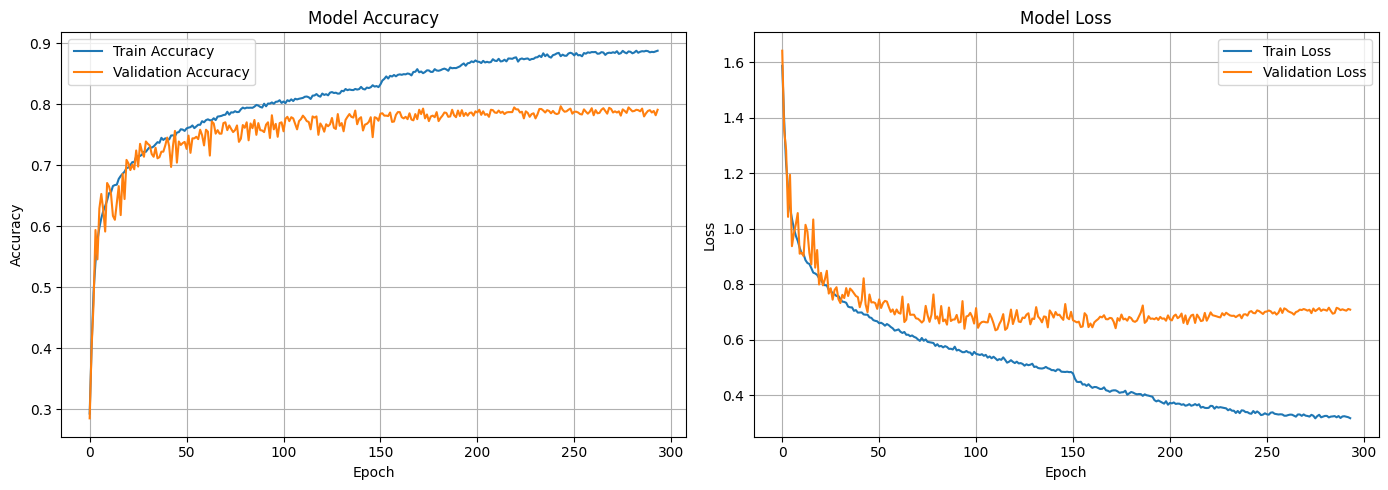

In [30]:
plot_training_history(history)

In [31]:
true_labels = test_gen.classes

In [32]:
sonuc=model.predict(test_gen)

25/25 [==============================] - 1s 29ms/step


In [33]:
sonuc_classes = np.argmax(sonuc, axis=1)

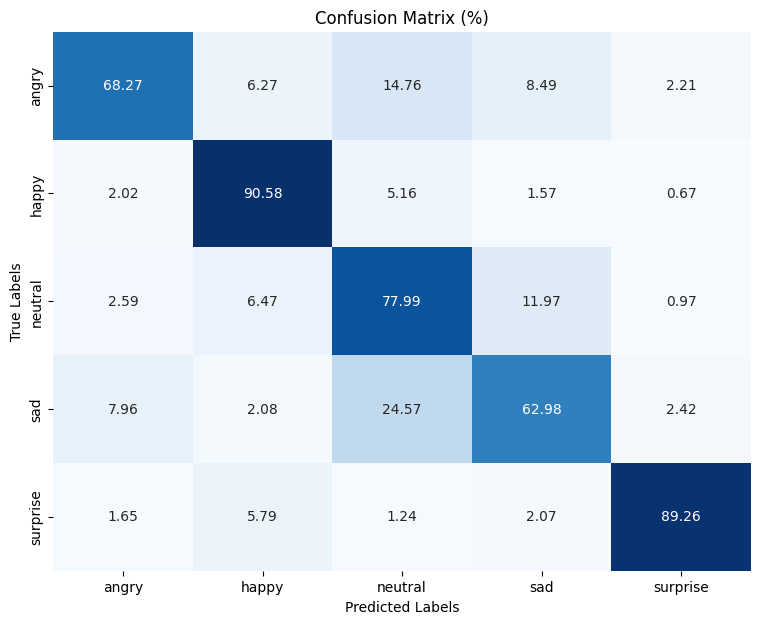

In [34]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import seaborn as sns

y_true = true_labels 
y_pred = sonuc_classes 

cm = confusion_matrix(y_true, y_pred)

class_labels = test_gen.class_indices.keys() 
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

cm_percentage = cm_df.div(cm_df.sum(axis=1), axis=0).multiply(100).round(2)

plt.figure(figsize=(9, 7))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (%)")
plt.show()

In [348]:
new_model=load_model("C:/Users/levent/CNN_87.h5")

In [31]:
img=cv2.imread("C:/Users/levent/output_frames/retrieved/93_0-00-04_Downloads.jpg")

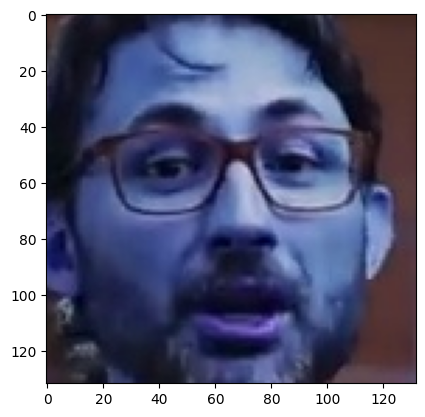

In [32]:
plt.imshow(img)
plt.show()

In [37]:
rgb_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
resized_image = cv2.resize(rgb_image, (48, 48))
preprocessed_image = np.expand_dims(resized_image, axis=-1)

In [38]:
preprocessed_image.shape

(48, 48, 1)

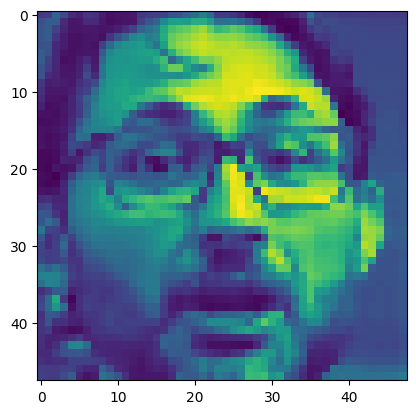

In [39]:
plt.imshow(preprocessed_image)
plt.show()

In [40]:
correct_input = preprocessed_image.reshape(1, 48, 48, 1)

In [41]:
correct_input.shape

(1, 48, 48, 1)

In [42]:
sonuc=model.predict(correct_input)

1/1 [==============================] - 0s 399ms/step


In [43]:
sonuc

array([[0.000000e+00, 6.431389e-23, 0.000000e+00, 0.000000e+00,
        1.000000e+00]], dtype=float32)

In [44]:
import numpy as np
predicted_class = np.argmax(sonuc)
print(f"Modelin tahmin ettiği sınıf: {predicted_class}")

Modelin tahmin ettiği sınıf: 4


In [65]:
predicted_class = np.argmax(sonuc, axis=-1)

In [66]:
predicted_class

array([0], dtype=int64)